# Neural Machine Translation

The NMT method performs translation via deep learning. 

This methodology comprises an encoder and a decoder. It vectorizes the source sentence through the encoder, condenses the information as a context vector, and generates the translated target sentence in the decoder based on the condensed information. 

Methodologies utilized for NMT include recurrent neural networks (RNNs), convolutional neural networks (CNNs), and the
Transformer model.
The Transformer model has exhibited better performance than the other approaches.

## Encoder-Decoder GRU & Glove Embeddings

1. one vocab for english, one different vocab for french
2. one embedding matrix for english, one different embedding matrix for french
3. add the END token to english sentences, and french sentences
4. the START token is only used in the decoder as the first token

We pad all sequences in the batch with 0s up to the length of the longest sequence (this is a classic process in variable length batches and can you find plenty of posts on this subject online). 

## Import Packages

In [2]:
import os                                 # to create 'serialised' directory
import pandas as pd
import numpy as np
import json                               # for serialising dictionaries
import pickle                             # for serialising numpy arrays
import re
import time
import random
import unicodedata                        # for data cleaning
import spacy                              # for tokenisation
from collections import Counter           # this is for tokens dictionary function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
from torch.nn.utils import clip_grad_value_, clip_grad_norm_

import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_row', None)              # show all rows of a dataframe
pd.set_option('display.max_column', None)           # show all columns of a dataframe
pd.set_option('display.max_colwidth', None)         # show the full width of columns
pd.set_option('precision', 2)                       # round to 2 decimal points
pd.options.display.float_format = '{:,.2f}'.format  # comma separators and two decimal points: 4756.7890 => 4,756.79 and 4656 => 4,656.00
torch.set_printoptions(profile='full')              # prints the whole tensor
# torch.set_printoptions(profile="default")         # reset to printing the truncated tensor

In [4]:
S_TOK = spacy.load('en_core_web_lg')                                         # for tokenisation
T_TOK = spacy.load('fr_core_news_lg')                                        # for tokenisation

batch_size = 256                                                              # for dataloader and training

In [5]:
torch.cuda.device_count()

C:\Users\Mari\miniconda3\envs\summer\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


0

In [6]:
try:
    torch.cuda.get_device_name(0)
except:
    print('no cuda available')

no cuda available


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')      # pytorch cuda
device

device(type='cpu')

## Functions

### 0. Random Seeds

https://pytorch.org/docs/stable/notes/randomness.html

In [8]:
seed_value = 0

def random_seeding(seed_value=seed_value):
    random.seed(seed_value)                            # python 
    np.random.seed(seed_value)                         # numpy - global seeding. Sklearn uses this internally therefore there is no need to set a random seed when using Sklearn 
    torch.manual_seed(seed_value)                      # pytorch cpu
    torch.set_deterministic(True)
    try:
        if device=='cuda': 
            torch.cuda.manual_seed_all(seed_value)     # pytorch gpu
    except:
        pass

### 1. Read Datasets

In [9]:
def read_data(filepath, filename, encoding='utf-8', index_col=False, header=None, sep=' '):
    full_path = '{}\{}'.format(filepath, filename)
    return pd.read_csv(full_path, encoding=encoding, index_col=index_col, header=header, sep=sep)

### 2. Data Cleaning

In [10]:
# Turn a Unicode string to plain ASCII: e.g. 'garçon' to 'garcon'
def unicodeToAscii(text):
    return ''.join(char for char in unicodedata.normalize('NFD', text) if unicodedata.category(char) != 'Mn')

# Clean sentences
def clean_tokenise(text, TOK):                            # to be used when tokenizing with spacy
    text = text.lower()
    text = unicodeToAscii(text)
    text = re.sub(r"([.,!?])", r" \1 ", text)              # r" \1" : adds a white space before whatever is referenced in the group r"()" in the first part of the regex
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)           # remove non-letter characters, e.g. "he's" becomes "he s"
    text = [token.text for token in TOK.tokenizer(text)]   # for tokenization with spacy
    text.append('<EOS>')
    return text

### 3. Serialisation / Deserialisation

https://www.tutorialspoint.com/object_oriented_python/object_oriented_python_serialization.htm

In the context of data storage, serialization is the process of translating data structures or object state into a format that can be stored (for example, in a file or memory buffer) or transmitted and reconstructed later.

In serialization, an object is transformed into a format that can be stored, so as to be able to deserialize it later and recreate the original object from the serialized format.

We can do this with Pickle, JSON, ...

In [11]:
def serialise(obj_type, filepath, filename, obj):
    full_path = '{}\{}'.format(filepath, filename)
    if obj_type == 'python':
        with open(full_path, 'w') as f:
            json.dump(obj, f)
            
    if obj_type in ['numpy', 'pandas', 'tensor']:
        with open(full_path, 'wb') as f:
            pickle.dump(obj, f)                                         # protocol 0 is printable ASCII
        
        

def deserialise(obj_type, filepath, filename):
    full_path = '{}\{}'.format(filepath, filename)
    if obj_type == 'python':
        with open(full_path, 'r') as f:
            return json.load(f)
            
    if obj_type in ['numpy', 'pandas', 'tensor']:
        with open(full_path, 'rb') as f:
            return pickle.load(f)                                        # protocol 0 is printable ASCII

### 4. Vocabulary from the Traing Corpus

In [12]:
def tokens_dict(series):
    tokens = series.explode()
    tokens = tokens.tolist()
    tokens = Counter(tokens)                                    # frequency distribution. This basically is a dictionary

    unique_words_before = len(tokens.keys())
    
    #To avoid 'RuntimeError: dictionary changed size during iteration' error, we need to make a .copy() of the dictionary.
    #This way we iterate over the original dictionary keys and delete elements on the fly.
    for k,v in tokens.copy().items():
        if v < 2:
            del tokens[k]

    tokens_dictionary = {word: i+1 for i,word in enumerate(tokens.keys())}   # word2index dictionary. The '+1' is to avoid the first word in the vocabulary to have index=0 because this will be reserved for padding (see comments in 'make_embedding_matrix())
    
    unique_words_after = len(tokens_dictionary.keys())
    
    tokens_dictionary['<SOS>'] = len(tokens_dictionary)+1
    tokens_dictionary['<UNK>'] = len(tokens_dictionary)+1
    tokens_dictionary[''] = len(tokens_dictionary)+1
    
    final_unique_words = len(tokens_dictionary.keys())
    
    reversed_dict = {int(v):k for k,v in tokens_dictionary.items()}
    
    return unique_words_before, unique_words_after, final_unique_words, tokens_dictionary, reversed_dict

### 5. All Glove Embeddings

In [13]:
def load_glove_from_file(glove_filepath):
    
    glove_embeddings_dict = {} 
    
    with open(glove_filepath, mode='r', encoding="utf-8") as f:
        for index,line in enumerate(f):
            line_split = line.split()
            word = line_split[0]
            glove_embeddings_dict[word] = np.array(line_split[1:], 'float32')
    
    return glove_embeddings_dict

### 6. Embedding Matrix

In [14]:
def make_embedding_matrix(glove_embeddings_dict, tokens_dictionary):  
    
    embedding_size = len(next(iter(glove_embeddings_dict.values())))          # length of each word embedding (e.g.300 dimensions)
    
    embeddings_matrix = np.zeros((len(tokens_dictionary)+1, embedding_size))  # len(tokens_dictionary) is the length of the vocabulary (i.e. unique words in the corpus)
                                                                              # the '+1' after len(tokens_dictionary) is necessary because we want the first embedding (i.e. at index 0) to be a zero vector; this will be used for the paddings (we want all the '0' paddings to be paired with the zero vector)
    not_in_glove = []
    for token,i in tokens_dictionary.items():
        if token in glove_embeddings_dict:
            embeddings_matrix[i, :] = glove_embeddings_dict[token]     
        else:
            not_in_glove.append(token)
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)                       # if word is not in Glove emebeddings, creates a new vector with random numbers drawn from pytorch xavier_uniform distribution
            embeddings_matrix[i, :] = embedding_i                

    return not_in_glove, embeddings_matrix

### 7. Encoding & Padding

In [15]:
def encoding(input_sequence, tokens_dictionary, max_len):
    encoded = np.zeros(max_len, dtype=int)
    
    encoded_lst = []
    if not input_sequence:
        encoded_lst.append(tokens_dictionary[''])
    else:
        for word in input_sequence:
            encoded_lst.append(tokens_dictionary.get(word, tokens_dictionary['<UNK>']))
            
    encoded_lst = np.array(encoded_lst)
    
    length = min(max_len, len(encoded_lst))
    encoded[:length] = encoded_lst[:length]
    return encoded

### 8. GRU Encoder-Decoder Model

In [16]:
class Encoder_GRU(nn.Module):
    def __init__(self, emb_dim, emb_num, hidden_size, num_layers=1, dropout_p=0.0, batch_first=True, bias=True,
                 bidirectional=False, pretrained_embeddings=None, padding_idx=0):  
        
        # pretrained_embeddings = embedding_matrix;
        # padding_idx=0 makes sure that the padding vector (which in our embedding matrix is at index 0) 
        # doesn't get updated during training when Freeze=False
        
        super(Encoder_GRU, self).__init__()                      
        
        self.emb_dim = emb_dim
        self.emb_num = emb_num
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_p = dropout_p
        self.batch_first = batch_first
        self.bias = bias
        self.bidirectional = bidirectional
        self.pretrained_embeddings = pretrained_embeddings
        self.padding_idx = padding_idx
        
        self.D = 1
        if self.bidirectional==True:
            self.D = 2
            
        # Initialise embedding layer    
        if self.pretrained_embeddings is None:

            self.emb = nn.Embedding(num_embeddings=self.emb_num,
                                    embedding_dim=self.emb_dim,
                                    padding_idx=self.padding_idx)      
        else:
            self.pretrained_embeddings = torch.from_numpy(self.pretrained_embeddings).float()
            # freeze=False : the tensor does not get updated in the learning process. 
            #Equivalent to self.emb.weight.requires_grad = False
            self.emb = nn.Embedding.from_pretrained(self.pretrained_embeddings, freeze=True, padding_idx=self.padding_idx)  
            
#             self.emb = nn.Embedding(embedding_dim=self.emb_dim,
#                                     num_embeddings=self.emb_num,
#                                     padding_idx=self.padding_idx,
#                                     _weight=self.pretrained_embeddings)
            
            
            # nn.Embedding is a model parameter layer, which is by default trainable.
            # If you want to fine-tune word vectors during training, these word vectors are treated as model parameters 
            # and are updated by backpropagation. You can also make it untrainable by freezing its gradient 
            # (False ==> freezes the backprop) 
#             self.emb.weight.requires_grad=False    
        
        
        # Initialise GRU model
        self.gru = nn.GRU(input_size=self.emb_dim, hidden_size=self.hidden_size, num_layers=self.num_layers, 
                          dropout=self.dropout_p, bidirectional=self.bidirectional, bias=self.bias, 
                          batch_first=self.batch_first) 
        
        # Regularization parameter
        self.dropout = nn.Dropout(self.dropout_p)
#         self.tag = True
        
        
    def forward(self, input_):
        # length of each sequence in the batch, ignoring the padding. This is needed for Packed Sequence
        lengths = ((input_ > 0)*1).sum(dim=1)               
        
        # input_ is a list of lists. It comes from the train_loader. E.g. [[3386, 603, 1112, 0],
        #                                                                  [176, 40, 97, 0]]
        embedded = self.dropout(self.emb(input_.long()))                

        batch_size = embedded.shape[0]

#         hidden = torch.randn(self.D*self.num_layers, batch_size, self.hidden_size)
        hidden = torch.zeros(self.D*self.num_layers, batch_size, self.hidden_size)

        packed = pack_padded_sequence(embedded, lengths, batch_first=self.batch_first, enforce_sorted=False)
        packed_output, hidden = self.gru(packed, hidden)

        unpacked_out, unpacked_lens = pad_packed_sequence(packed_output)
        output = unpacked_out.permute(1, 2, 0)
        
        hidden = hidden[-1,:,:].unsqueeze(0)           # this extract the last hidden state in case of multiple GRU layers
        output = output[:, -self.hidden_size:, :]      # this extract the bottom hidden states in case of bidirectional GRUs
            
        return output, hidden

In [17]:
class Decoder_Bahdanau_GRU(nn.Module):
    def __init__(self, emb_dim, emb_num, encoder_hidden_size, decoder_hidden_size, max_length,
                 v_dim=3, num_layers=1, dropout_p=0.1, batch_first=True, bias=True,
                 bidirectional=False, pretrained_embeddings=None, padding_idx=0):
    
        super(Decoder_Bahdanau_GRU, self).__init__()
        
        self.emb_dim = emb_dim
        self.emb_num = emb_num
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.max_length = max_length
        self.v_dim = v_dim
        self.num_layers = num_layers
        self.dropout_p = dropout_p
        self.batch_first = batch_first
        self.bias = bias
        self.bidirectional = bidirectional
        self.pretrained_embeddings = pretrained_embeddings
        self.padding_idx = padding_idx
        
        self.D = 1
        if self.bidirectional==True:
            self.D = 2
        
        # Initialise Embedding Layer
        if self.pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=self.emb_dim,
                                    num_embeddings=self.emb_num,
                                    padding_idx=self.padding_idx)     
        else:
            self.pretrained_embeddings = torch.from_numpy(self.pretrained_embeddings).float()
            # freeze=False : the tensor does not get updated in the learning process.
            # Equivalent to self.emb.weight.requires_grad = False
            self.emb = nn.Embedding.from_pretrained(self.pretrained_embeddings, freeze=True, padding_idx=self.padding_idx)
        
        # Initialise Attention
        self.v = nn.Linear(self.v_dim, 1, bias=False)
        self.w1 = nn.Linear(self.decoder_hidden_size, self.v_dim, bias=False)                # decoder_hidden_state
        self.w2 = nn.Linear(self.encoder_hidden_size, self.v_dim, bias=False)                # encoder_output
        
        # Initialise GRU
        self.gru = nn.GRU(input_size=self.emb_dim+self.decoder_hidden_size, hidden_size=self.decoder_hidden_size, 
                          num_layers=self.num_layers, dropout=self.dropout_p, bidirectional=self.bidirectional, 
                          bias=self.bias, batch_first=self.batch_first)
        
        
        
        # Initialise Linear Layer
        self.fc1 = nn.Linear(self.decoder_hidden_size, self.emb_num, bias=False)
        
        # Regularization parameter
        self.dropout = nn.Dropout(self.dropout_p)
        
        self.log_softmax = nn.LogSoftmax(dim=1)
        

# input_ is a tensor of shape [batch_size, 1]; for instance if batch_size=3: [[1.],
#                                                                             [1.],
#                                                                             [1.]]
    def forward(self, input_, decoder_hidden, encoder_output):
        embedded = self.emb(input_.long())
        
        hidden = decoder_hidden
        
        w1h = self.w1(hidden)
        w1h = w1h.permute(1,0,2)
        w2eo = self.w2(encoder_output.permute(0,2,1)) 
        sum_ = w2eo + w1h.expand_as(w2eo)
        tanh_ = torch.tanh(sum_)
        alignment_scores = self.v(tanh_)
        
        # Mask alignment_scores so that the softmax calculation to get the attn_weights will ingnore the paddings
        mask = (alignment_scores == 0) * 1
        masked_alignments = alignment_scores.masked_fill(mask=mask, value=-np.inf)
        
        attn_weights = F.softmax(masked_alignments, dim=1)                # this is the normal softmax 
        attn_weights = self.dropout(attn_weights)
        
        context_vector = torch.matmul(attn_weights.permute(0,2,1), encoder_output.permute(0,2,1))
        print('Decoder context vector shape: {}'.format(context_vector.shape))
        
        concat = torch.cat((embedded, context_vector.squeeze(1)), dim=1)
        print('Decoder concat shape: {}'.format(concat.shape))
        concat = concat.unsqueeze(1)
        print('Decoder concat shape: {}'.format(concat.shape))
        print('Decoder hidden shape: {}'.format(hidden.shape))
        
        # Cannot use packing in the decoder because tokens are processed one at a time
        output, hidden = self.gru(concat, hidden)
        output = self.fc1(output)
        output = self.log_softmax(output[:,0])          # this is log softmax

        return output, hidden, attn_weights

In [18]:
class Decoder_Luong_GRU(nn.Module):
    def __init__(self, emb_dim, emb_num, encoder_hidden_size, decoder_hidden_size, max_length, attn_method='dot',
                 num_layers=1, dropout_p=0.1, batch_first=True, bias=True,
                 bidirectional=False, pretrained_embeddings=None, padding_idx=0):
    
        super(Decoder_Luong_GRU, self).__init__()
        
        self.emb_dim = emb_dim
        self.emb_num = emb_num
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.max_length = max_length
        self.attn_method = attn_method
        self.num_layers = num_layers
        self.dropout_p = dropout_p
        self.batch_first = batch_first
        self.bias = bias
        self.bidirectional = bidirectional
        self.pretrained_embeddings = pretrained_embeddings
        self.padding_idx = padding_idx
        
        self.D = 1
        if self.bidirectional==True:
            self.D = 2
        
        # Initialise Embedding Layer
        if self.pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=self.emb_dim,
                                    num_embeddings=self.emb_num,
                                    padding_idx=self.padding_idx)     
        else:
            self.pretrained_embeddings = torch.from_numpy(self.pretrained_embeddings).float()
            # freeze=False : the tensor does not get updated in the learning process.
            # Equivalent to self.emb.weight.requires_grad = False
            self.emb = nn.Embedding.from_pretrained(self.pretrained_embeddings, freeze=True, padding_idx=self.padding_idx)
        
        # Initialise GRU
        self.gru = nn.GRU(input_size=self.emb_dim, hidden_size=self.decoder_hidden_size, num_layers=self.num_layers,
                          dropout=self.dropout_p, bidirectional=self.bidirectional, bias=self.bias,
                          batch_first=self.batch_first)
        
        # Initialise Attention for 'multiplicative' method
        if self.attn_method == 'multiplicative':
            self.w = nn.Linear(self.decoder_hidden_size, self.encoder_hidden_size, bias=False)
        
        # Initialise Linear Layer
        self.fc1 = nn.Linear(self.encoder_hidden_size+self.decoder_hidden_size, self.emb_num, bias=False)
        
        self.dropout = nn.Dropout(self.dropout_p)
        self.log_softmax = nn.LogSoftmax(dim=1)
        
            
# input_ is a tensor of shape [batch_size, 1]; for instance if batch_size=3: [[1.],
#                                                                             [1.],
#                                                                             [1.]]
    def forward(self, input_, decoder_hidden, encoder_output):
        embedded = self.emb(input_.long())
        
        hidden = decoder_hidden
        
        # Cannot use packing in the decoder because tokens are processed one at a time
        output, hidden = self.gru(embedded.unsqueeze(1), hidden)
        
        # Attention scores
        if self.attn_method == 'dot':
            #.matmul works on matrix-vector multiplication, whereas .bmm only works on matrix-matrix multiplications
            alignment_scores = torch.matmul(hidden.permute(1,0,2), encoder_output)
        elif self.attn_method == 'multiplicative':
            attn_hidden = self.w(hidden)
            alignment_scores = torch.matmul(attn_hidden.permute(1,0,2), encoder_output)
        
        # Mask alignment_scores so that the softmax calculation to get the attn_weights will ingnore the paddings
        mask = (alignment_scores == 0) * 1
        masked_alignments = alignment_scores.masked_fill(mask=mask, value=-np.inf)
        
        attn_weights = F.softmax(masked_alignments.permute(0,2,1), dim=1)                # this is the normal softmax 
        attn_weights = self.dropout(attn_weights)
        context_vector = torch.matmul(attn_weights.permute(0,2,1), encoder_output.permute(0,2,1))
        concat = torch.cat((hidden.squeeze(0), context_vector.squeeze(1)), 1)
        output = self.log_softmax(self.fc1(concat))                                       # this is log softmax

        return output, hidden, attn_weights

### 10. Parameters

In [19]:
def params(full_embedding_layer_name):
    for param in full_embedding_layer_name.parameters():
        return param


def check_params(classifier_name):
    for name, child in classifier_name.named_children():
        print('Layer name: {} --- {}'.format(name, child), end='\n\n')            
        print('ToT Params: {:,}'. format(sum(p.numel() for p in child.parameters())), end='\n\n') 
    
        count = 0
        for param in child.parameters():
            print('Param length: {:,}'.format(len(param)), end='\n\n')
            print(param, end='\n\n')
            print('Are parameters being updated during backprop? {}'.format(param.requires_grad), end='\n\n')
            count += 1

        print('Total Sets of Parameters: {}'.format(count), end='\n\n')
        print('*' * 90)
    

def num_params(classifier_name):
    
    # PyTorch torch.numel() method returns the total number of elements in the input tensor
    trainable_parameters = sum(param.numel() for param in classifier_name.parameters() if param.requires_grad)  
    all_parameters = sum(param.numel() for param in classifier_name.parameters())  
    
    return trainable_parameters, all_parameters

### 11. Inference

In [20]:
def prepare_new_data(lst_of_lsts, source_TOK, source_dict, source_max_len):
    series = pd.Series(lst_of_lsts)
    series = series.apply(lambda x: clean_tokenise(x, source_TOK))
    series = series.apply(lambda x: encoding(x, source_dict, source_max_len))
    tensor = torch.tensor(series)
    return tensor

In [21]:
def infer_encoder_decoder(dataloader, n, y_dict_w2i, y_dict_i2w):
    encoder.eval() # .eval() tells PyTorch that we do not want to perform back-propagation during inference
    decoder.eval()
    
    with torch.no_grad():
        for i, new_data in enumerate(dataloader):
            new_data = new_data.to(device)

            encoder_output, encoder_hidden = encoder(input_=new_data)
            decoder_hidden = encoder_hidden
            decoder_input = torch.tensor([y_dict_w2i['<SOS>']]).expand(len(new_data))

            for _ in range(n):
                print(_)
                decoder_output, decoder_hidden, attn_weights = decoder(input_=decoder_input, 
                                                                       decoder_hidden=decoder_hidden,
                                                                       encoder_output=encoder_output)


                max_value, max_idx = decoder_output.max(dim=1)
                print('max idx: {} --- top word: {} --- max value: {}'.format(max_idx, 
                                                                              y_dict_i2w[str(max_idx.item())], 
                                                                              max_value))

                decoder_input = max_idx

## Code

### Random Seeds

In [22]:
random_seeding()

### Directories

In [23]:
dataset_directory = r'C:\Users\Mari\Desktop\MACHINE_LEARNING\NLP_Stanford_University\BOOK\NMT\data'
csv_file = 'simplest_eng_fra.csv'

serialise_directory = r'C:\Users\Mari\Desktop\MACHINE_LEARNING\NLP_Stanford_University\BOOK\NMT\serialised'
saved_model = r'C:\Users\Mari\Desktop\MACHINE_LEARNING\NLP_Stanford_University\BOOK\NMT\saved_model'

In [24]:
# Create the 'serialised' directory if it doesn't exist

try:
    os.makedirs(serialise_directory)
    os.makedirs(saved_model)
except FileExistsError:
    # directory already exists
    pass

### Read / Split / Clean Datasets

In [25]:
data = read_data(dataset_directory, csv_file, encoding='utf-8', index_col=0, header=0, sep=',')
print(data.shape)
print(data.head())

(13062, 3)
                     source_language  split  \
0     he 's the cutest boy in town .  train   
1                he 's a nonsmoker .  train   
2            he 's smarter than me .  train   
3         he 's a lovely young man .  train   
4  he 's three years older than me .  train   

                             target_language  
0  c'est le garçon le plus mignon en ville .  
1                        il est non-fumeur .  
2          il est plus intelligent que moi .  
3            c'est un adorable jeune homme .  
4           il a trois ans de plus que moi .  


In [26]:
# drop duplicate translations
data = data.drop_duplicates()
print(data.shape)
print(data.head())

(13060, 3)
                     source_language  split  \
0     he 's the cutest boy in town .  train   
1                he 's a nonsmoker .  train   
2            he 's smarter than me .  train   
3         he 's a lovely young man .  train   
4  he 's three years older than me .  train   

                             target_language  
0  c'est le garçon le plus mignon en ville .  
1                        il est non-fumeur .  
2          il est plus intelligent que moi .  
3            c'est un adorable jeune homme .  
4           il a trois ans de plus que moi .  


In [27]:
# Shuffle the data to remove bias in dev set selection.
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
print(data.head())

(13060, 3)
                                   source_language  split  \
0                                i 'm not asleep .  train   
1                             they 're nice guys .    val   
2  i am looking forward to seeing you again soon .  train   
3  you 're not telling me anything i do n't know .  train   
4                            he is very sociable .   test   

                          target_language  
0                je ne suis pas endormi .  
1                ce sont de chics types .  
2  je me réjouis de vous revoir bientôt .  
3    vous ne me dites rien que j'ignore .  
4                  il est très sociable .  


In [28]:
# Remove empty rows
data = data.dropna()
print(data.shape)
print(data.head())

(13060, 3)
                                   source_language  split  \
0                                i 'm not asleep .  train   
1                             they 're nice guys .    val   
2  i am looking forward to seeing you again soon .  train   
3  you 're not telling me anything i do n't know .  train   
4                            he is very sociable .   test   

                          target_language  
0                je ne suis pas endormi .  
1                ce sont de chics types .  
2  je me réjouis de vous revoir bientôt .  
3    vous ne me dites rien que j'ignore .  
4                  il est très sociable .  


In [29]:
X_train_full = data.loc[data['split'] == 'train', 'source_language'].copy(deep=True)
X_val_full = data.loc[data['split'] == 'val', 'source_language'].copy(deep=True)
X_test_full = data.loc[data['split'] == 'test', 'source_language'].copy(deep=True)
y_train_full = data.loc[data['split'] == 'train', 'target_language'].copy(deep=True)
y_val_full = data.loc[data['split'] == 'val', 'target_language'].copy(deep=True)
y_test_full = data.loc[data['split'] == 'test', 'target_language'].copy(deep=True)

In [30]:
print(type(X_train_full), X_train_full.shape)
print(type(X_val_full), X_val_full.shape)
print(type(X_test_full), X_test_full.shape)
print(type(y_train_full), y_train_full.shape)
print(type(y_val_full), y_val_full.shape)
print(type(y_test_full), y_test_full.shape)

<class 'pandas.core.series.Series'> (9136,)
<class 'pandas.core.series.Series'> (1955,)
<class 'pandas.core.series.Series'> (1969,)
<class 'pandas.core.series.Series'> (9136,)
<class 'pandas.core.series.Series'> (1955,)
<class 'pandas.core.series.Series'> (1969,)


### Samples

In [31]:
# train_rows = 5000
# val_rows = int(train_rows / 0.7 / 2)
# test_rows = val_rows

train_rows = len(X_train_full)
val_rows = len(X_val_full)
test_rows = len(X_test_full)

In [32]:
X_train_subset = X_train_full.head(train_rows).copy(deep=True)
y_train_subset = y_train_full.head(train_rows).copy(deep=True)
print(X_train_subset.shape)
print(y_train_subset.shape)
print(X_train_subset.head())
print(y_train_subset.head())

(9136,)
(9136,)
0                                  i 'm not asleep .
2    i am looking forward to seeing you again soon .
3    you 're not telling me anything i do n't know .
5                    i 'm doing it in spite of you .
6                      i 'm asking you as a friend .
Name: source_language, dtype: object
0                  je ne suis pas endormi .
2    je me réjouis de vous revoir bientôt .
3      vous ne me dites rien que j'ignore .
5                   je le fais malgré toi .
6      je vous le demande en tant qu'amie .
Name: target_language, dtype: object


In [33]:
X_val_subset = X_val_full.head(val_rows).copy(deep=True)
y_val_subset = y_val_full.head(val_rows).copy(deep=True)
print(X_val_subset.shape)
print(y_val_subset.shape)
print(X_val_subset.head())
print(y_val_subset.head())

(1955,)
(1955,)
1                they 're nice guys .
8     she is paralyzed in both legs .
19                   we 're sloshed .
28               we 're really good .
29          he 's a weak-willed man .
Name: source_language, dtype: object
1                 ce sont de chics types .
8     elle est paralysée des deux jambes .
19                   nous sommes bourrés .
28             nous sommes vraiment bons .
29      c'est un homme de faible volonté .
Name: target_language, dtype: object


In [34]:
X_test_subset = X_test_full.head(test_rows).copy(deep=True)
y_test_subset = y_test_full.head(test_rows).copy(deep=True)
print(X_test_subset.shape)
print(y_test_subset.shape)
print(X_test_subset.head())
print(y_test_subset.head())

(1969,)
(1969,)
4                                           he is very sociable .
7                                         you 're very generous .
9     i 'm not sure what it was , but it sounded like a gunshot .
10                                           we 're ready to go .
18                                      they 're all against me .
Name: source_language, dtype: object
4                                                                        il est très sociable .
7                                                                         tu es très généreux .
9     je ne suis pas sûre de ce dont il s'agissait , mais ça a fait le bruit d'une détonation .
10                                                                nous sommes prêtes à partir .
18                                                                   ils sont tous contre moi .
Name: target_language, dtype: object


### Data Cleaning And Tokenization

In addition to creating a subset that has three partitions for training, validation, and testing, we also minimally clean the data by adding whitespace around punctuation symbols and removing extraneous symbols that aren’t punctuation for all the splits.


1. **apply** works on a row / column basis of a DataFrame 
2. **applymap** works element-wise on a DataFrame
3. **map** works element-wise on a Series

In [35]:
X_train = X_train_subset.map(lambda x: clean_tokenise(text=x, TOK=S_TOK))
X_val = X_val_subset.map(lambda x: clean_tokenise(text=x, TOK=S_TOK))
X_test = X_test_subset.map(lambda x: clean_tokenise(text=x, TOK=S_TOK))
y_train = y_train_subset.map(lambda x: clean_tokenise(text=x, TOK=T_TOK))
y_val = y_val_subset.map(lambda x: clean_tokenise(text=x, TOK=T_TOK))
y_test = y_test_subset.map(lambda x: clean_tokenise(text=x, TOK=T_TOK))

In [36]:
print(X_train.head(), '\n')
print(y_train.head(), '\n\n')

print(X_val.head(), '\n')
print(y_val.head(), '\n\n')

print(X_test.head(), '\n')
print(y_test.head())

0                                         [i, m, not, asleep, ., <EOS>]
2     [i, am, looking, forward, to, seeing, you, again, soon, ., <EOS>]
3    [you, re, not, telling, me, anything, i, do, n, t, know, ., <EOS>]
5                       [i, m, doing, it, in, spite, of, you, ., <EOS>]
6                          [i, m, asking, you, as, a, friend, ., <EOS>]
Name: source_language, dtype: object 

0                    [je, ne, suis, pas, endormi, ., <EOS>]
2    [je, me, rejouis, de, vous, revoir, bientot, ., <EOS>]
3     [vous, ne, me, dites, rien, que, j, ignore, ., <EOS>]
5                     [je, le, fais, malgre, toi, ., <EOS>]
6     [je, vous, le, demande, en, tant, qu, amie, ., <EOS>]
Name: target_language, dtype: object 


1                   [they, re, nice, guys, ., <EOS>]
8     [she, is, paralyzed, in, both, legs, ., <EOS>]
19                       [we, re, sloshed, ., <EOS>]
28                  [we, re, really, good, ., <EOS>]
29           [he, s, a, weak, willed, man, ., <EO

### Max length of source and target sentences

In [37]:
X_train_max_len = X_train.map(lambda x: len(x)).max()
X_val_max_len = X_val.map(lambda x: len(x)).max()
X_test_max_len = X_test.map(lambda x: len(x)).max()
y_train_max_len = y_train.map(lambda x: len(x)).max()
y_val_max_len = y_val.map(lambda x: len(x)).max()
y_test_max_len = y_test.map(lambda x: len(x)).max()

In [38]:
print(X_train_max_len)
print(X_val_max_len)
print(X_test_max_len)
print(y_train_max_len)
print(y_val_max_len)
print(y_test_max_len)

26
22
22
27
24
25


In [39]:
# for encoding and padding  
s_max_len = max(X_train_max_len, X_val_max_len, X_test_max_len)
t_max_len = max(y_train_max_len, y_val_max_len, y_test_max_len)

In [40]:
print(s_max_len)
print(t_max_len)

26
27


In [41]:
# This is needed to calculate the epoch loss per token during training
# We do not include the <SOS> token in the count!
y_train_tot_tokens = y_train.map(lambda x: len(x)).sum()
y_val_tot_tokens = y_val.map(lambda x: len(x)).sum()
y_test_tot_tokens = y_test.map(lambda x: len(x)).sum()

In [42]:
print(y_train_tot_tokens)
print(y_val_tot_tokens)
print(y_test_tot_tokens)

75403
15935
16186


### Glove

In [43]:
# From glove txt, create a dictionary of all glove embeddings where KEY is a WORD, and VALUE is a NUMPY ARRAY:
glove_embeddings = load_glove_from_file('C:/GloVe/glove.6B.300d.txt')

### Create Vocabulary From Training Corpus

The embedding matrix (see later) is created only from the training dataset.

The training dataset should be sufficiently rich/representative enough to cover all data you expect to see in the future.

New data must have the same integer encoding as the training data prior to being mapped onto the embedding when making a prediction.

In [44]:
# create a DICT of the unique words in the training set
X_words_before, X_words_after, X_final_words, X_dict_w2i, X_dict_i2w = tokens_dict(X_train)
y_words_before, y_words_after, y_final_words, y_dict_w2i, y_dict_i2w = tokens_dict(y_train)

In [45]:
print(X_words_before)
print(X_words_after)
print(len(X_dict_w2i))
print()
print(y_words_before)
print(y_words_after)
print(len(y_dict_w2i))

2986
1824
1827

4445
2353
2356


### Create Embedding Matrix

The embedding is created from the training dataset.

It should be sufficiently rich/representative enough to cover all data you expect to in the future.

New data must have the same integer encoding as the training data prior to being mapped onto the embedding when making a prediction.

In [46]:
X_excluded, X_embeddings_matrix = make_embedding_matrix(glove_embeddings, X_dict_w2i)
y_excluded, y_embeddings_matrix = make_embedding_matrix(glove_embeddings, y_dict_w2i)

In [47]:
# print(X_excluded)
# print(len(X_excluded))
# print(type(X_embeddings_matrix))
# print(X_embeddings_matrix.shape)
# print()
# print(y_excluded)
# print(len(y_excluded))
# print(type(y_embeddings_matrix))
# print(y_embeddings_matrix.shape)

### Encoding Training Dataset

We need to convert our text into a numerical form that can be fed to our model as input.

1. We have create a vocabulary (see section '10. Vocabulary') where each key is a unique word from the training corpus, and each value is the index of that word in the 'tokens' dictionary.
2. Choose the maximum length of any review.
3. Encode each list of tokens by replacing each word with its index from the 'tokens' dictionary.

Note: **mean_len** (see below) is the mean of tokens length in the training set. We set the max length of the encoded reviews equal to the mean_len.

In [48]:
X_train_encoded = X_train.map(lambda x: encoding(input_sequence=x, tokens_dictionary=X_dict_w2i, max_len=s_max_len))
X_val_encoded = X_val.map(lambda x: encoding(input_sequence=x, tokens_dictionary=X_dict_w2i, max_len=s_max_len))
X_test_encoded = X_test.map(lambda x: encoding(input_sequence=x, tokens_dictionary=X_dict_w2i, max_len=s_max_len))

In [49]:
y_train_encoded = y_train.map(lambda x: encoding(input_sequence=x, tokens_dictionary=y_dict_w2i, max_len=t_max_len))
y_val_encoded = y_val.map(lambda x: encoding(input_sequence=x, tokens_dictionary=y_dict_w2i, max_len=t_max_len))
y_test_encoded = y_test.map(lambda x: encoding(input_sequence=x, tokens_dictionary=y_dict_w2i, max_len=t_max_len))

In [50]:
print(X_train_encoded.head())
print()
print(y_train_encoded.head())

0             [1, 2, 3, 4, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2        [1, 7, 8, 9, 10, 11, 12, 13, 14, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3    [12, 15, 3, 16, 17, 18, 1, 19, 20, 21, 22, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
5       [1, 2, 23, 24, 25, 26, 27, 12, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
6        [1, 2, 28, 12, 29, 30, 31, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Name: source_language, dtype: object

0           [1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2       [1, 8, 9, 10, 11, 12, 13, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3     [11, 2, 8, 14, 15, 16, 17, 18, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
5       [1, 19, 20, 21, 22, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
6    [1, 11, 19, 23, 24, 25, 26, 27, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Name: target_language, dtyp

In [51]:
print(X_val_encoded.head())
print()
print(y_val_encoded.head())

1        [58, 15, 159, 1071, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
8     [37, 38, 1826, 25, 33, 1826, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
19         [45, 15, 1826, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
28        [45, 15, 168, 155, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
29    [78, 53, 30, 447, 1826, 198, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Name: source_language, dtype: object

1        [149, 75, 10, 2355, 2075, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
8      [36, 37, 2355, 143, 272, 2355, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
19            [44, 45, 2355, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
28           [44, 45, 188, 995, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
29    [131, 37, 87, 220, 10, 1033, 1826, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [52]:
print(X_test_encoded.head())
print()
print(y_test_encoded.head())

4                    [78, 38, 42, 1826, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
7                     [12, 15, 42, 599, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
9     [1, 2, 3, 117, 243, 24, 353, 136, 350, 24, 1676, 629, 30, 1677, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
10                   [45, 15, 388, 10, 95, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
18                    [58, 15, 68, 50, 17, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Name: source_language, dtype: object

4                                [78, 37, 42, 781, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
7                               [28, 29, 42, 1021, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
9     [1, 2, 3, 4, 360, 10, 149, 1377, 78, 174, 2133, 50, 401, 102, 30, 181, 19, 2135, 109, 38, 2249, 6, 7, 0, 0, 0, 0]
10                             [44, 45, 597, 30, 128, 6, 7, 0, 0, 0, 0, 

### PyTorch Dataset

In [53]:
# Convert pd.Series to PyTorch Tensors
# NB: set the values in X_train, X_val and X_test as a list of arrays (as opposed to array of arrays) --- see above

x_train_tensor = torch.Tensor(list(X_train_encoded.values))
x_val_tensor = torch.Tensor(list(X_val_encoded.values))
x_test_tensor = torch.Tensor(list(X_test_encoded.values))
y_train_tensor = torch.Tensor(list(y_train_encoded.values))
y_val_tensor = torch.Tensor(list(y_val_encoded.values))
y_test_tensor = torch.Tensor(list(y_test_encoded.values))

In [54]:
# Create a full dataset (like a DataFrame in Pandas) from the two tensors
train_dataset =  TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

### Serialisation

In [55]:
# Serialise original datasets
serialise('pandas', serialise_directory, 'X_train_subset', X_train_subset)
serialise('pandas', serialise_directory, 'X_val_subset', X_val_subset)
serialise('pandas', serialise_directory, 'X_test_subset', X_test_subset)
serialise('pandas', serialise_directory, 'y_train_subset', y_train_subset)
serialise('pandas', serialise_directory, 'y_val_subset', y_val_subset)
serialise('pandas', serialise_directory, 'y_test_subset', y_test_subset)

In [56]:
# Serialise tokenised datasets
serialise('pandas', serialise_directory, 'X_train', X_train)
serialise('pandas', serialise_directory, 'X_val', X_val)
serialise('pandas', serialise_directory, 'X_test', X_test)
serialise('pandas', serialise_directory, 'y_train', y_train)
serialise('pandas', serialise_directory, 'y_val', y_val)
serialise('pandas', serialise_directory, 'y_test', y_test)

In [57]:
# Serialise lengths
serialise('numpy', serialise_directory, 's_max_len', s_max_len)
serialise('numpy', serialise_directory, 't_max_len', t_max_len)

In [58]:
# Serialise tot tokens
serialise('numpy', serialise_directory, 'y_train_tot_tokens', y_train_tot_tokens)
serialise('numpy', serialise_directory, 'y_val_tot_tokens', y_val_tot_tokens)
serialise('numpy', serialise_directory, 'y_test_tot_tokens', y_test_tot_tokens)

In [59]:
# Serialise glove embeddings (althought 'glove_embeddings' is a dictionary, its values are numpy arrays therefore we need to choose 'numpy')
serialise('numpy', serialise_directory, 'glove_embeddings', glove_embeddings)

In [60]:
# Serialise dictionaries
serialise('python', serialise_directory, 'X_dict_w2i', X_dict_w2i)
serialise('python', serialise_directory, 'y_dict_w2i', y_dict_w2i)
serialise('python', serialise_directory, 'X_dict_i2w', X_dict_i2w)
serialise('python', serialise_directory, 'y_dict_i2w', y_dict_i2w)

In [61]:
# Serialise embedding matrices
serialise('numpy', serialise_directory, 'X_embeddings_matrix', X_embeddings_matrix)
serialise('python', serialise_directory, 'X_excluded', X_excluded)
serialise('numpy', serialise_directory, 'y_embeddings_matrix', y_embeddings_matrix)
serialise('python', serialise_directory, 'y_excluded', y_excluded)

In [62]:
# Serialise encoded datasets
serialise('pandas', serialise_directory, 'X_train_encoded', X_train_encoded)
serialise('pandas', serialise_directory, 'X_val_encoded', X_val_encoded)
serialise('pandas', serialise_directory, 'X_test_encoded', X_test_encoded)
serialise('pandas', serialise_directory, 'y_train_encoded', y_train_encoded)
serialise('pandas', serialise_directory, 'y_val_encoded', y_val_encoded)
serialise('pandas', serialise_directory, 'y_test_encoded', y_test_encoded)

In [63]:
# Serialise tensors
serialise('tensor', serialise_directory, 'x_train_tensor', x_train_tensor)
serialise('tensor', serialise_directory, 'x_val_tensor', x_val_tensor)
serialise('tensor', serialise_directory, 'x_test_tensor', x_test_tensor)
serialise('tensor', serialise_directory, 'y_train_tensor', y_train_tensor)
serialise('tensor', serialise_directory, 'y_val_tensor', y_val_tensor)
serialise('tensor', serialise_directory, 'y_test_tensor', y_test_tensor)

In [64]:
# Serialise PyTorch Dataset
serialise('tensor', serialise_directory, 'train_dataset', train_dataset)
serialise('tensor', serialise_directory, 'val_dataset', val_dataset)
serialise('tensor', serialise_directory, 'test_dataset', test_dataset)

### Deserialisation

In [65]:
# Deserialise original datasets
X_train_subset = deserialise('pandas', serialise_directory, 'X_train_subset')
X_val_subset = deserialise('pandas', serialise_directory, 'X_val_subset')
X_test_subset = deserialise('pandas', serialise_directory, 'X_test_subset')
y_train_subset = deserialise('pandas', serialise_directory, 'y_train_subset')
y_val_subset = deserialise('pandas', serialise_directory, 'y_val_subset')
y_test_subset = deserialise('pandas', serialise_directory, 'y_test_subset')

In [66]:
# Deserialise datasets after tokenisation
X_train = deserialise('pandas', serialise_directory, 'X_train')
X_val = deserialise('pandas', serialise_directory, 'X_val')
X_test = deserialise('pandas', serialise_directory, 'X_test')
y_train = deserialise('pandas', serialise_directory, 'y_train')
y_val = deserialise('pandas', serialise_directory, 'y_val')
y_test = deserialise('pandas', serialise_directory, 'y_test')

In [67]:
# # Check if there are empty sentences in the X datasets
# lengths_train = X_train.map(lambda x: len(x))
# lengths_val = X_val.map(lambda x: len(x))
# lengths_test = X_test.map(lambda x: len(x))

# idx_train = lengths_train[lengths_train==0]
# idx_val = lengths_val[lengths_val==0]
# idx_test = lengths_test[lengths_test==0]

# print(len(idx_train))
# print(len(idx_val))
# print(len(idx_test))

# print(idx_train.index)
# print(idx_val.index)
# print(idx_test.index)

# print(X_train[idx_train.index])
# print(X_val[idx_val.index])
# print(X_test[idx_test.index])

In [68]:
# # Check if there are empty sentences in the y datasets
# lengths_ytrain = y_train.map(lambda x: len(x))
# lengths_yval = y_val.map(lambda x: len(x))
# lengths_ytest = y_test.map(lambda x: len(x))

# idx_ytrain = lengths_ytrain[lengths_ytrain==0]
# idx_yval = lengths_yval[lengths_yval==0]
# idx_ytest = lengths_ytest[lengths_ytest==0]

# print(len(idx_ytrain))
# print(len(idx_yval))
# print(len(idx_ytest))

# print(idx_ytrain.index)
# print(idx_yval.index)
# print(idx_ytest.index)

# print(y_train[idx_ytrain.index])
# print(y_val[idx_yval.index])
# print(y_test[idx_ytest.index])

In [69]:
# Deserialise lengths
s_max_len = deserialise('numpy', serialise_directory, 's_max_len')
t_max_len = deserialise('numpy', serialise_directory, 't_max_len')

In [70]:
# Deserialise tot tokens
y_train_tot_tokens = deserialise('numpy', serialise_directory, 'y_train_tot_tokens')
y_val_tot_tokens = deserialise('numpy', serialise_directory, 'y_val_tot_tokens')
y_test_tot_tokens = deserialise('numpy', serialise_directory, 'y_test_tot_tokens')

In [71]:
# Deserialise glove embeddings
glove_embeddings = deserialise('numpy', serialise_directory, 'glove_embeddings')

In [72]:
# Deserialise dictionaries
X_dict_w2i = deserialise('python', serialise_directory, 'X_dict_w2i')
y_dict_w2i = deserialise('python', serialise_directory, 'y_dict_w2i')
X_dict_i2w = deserialise('python', serialise_directory, 'X_dict_i2w')
y_dict_i2w = deserialise('python', serialise_directory, 'y_dict_i2w')

In [73]:
# Deserialise embedding matrices
X_embeddings_matrix = deserialise('numpy', serialise_directory, 'X_embeddings_matrix')
X_excluded = deserialise('python', serialise_directory, 'X_excluded')
y_embeddings_matrix = deserialise('numpy', serialise_directory, 'y_embeddings_matrix')
y_excluded = deserialise('python', serialise_directory, 'y_excluded')

In [74]:
# Deserialise encoded datasets
X_train_encoded = deserialise('numpy', serialise_directory, 'X_train_encoded')
X_val_encoded = deserialise('numpy', serialise_directory, 'X_val_encoded')
X_test_encoded = deserialise('numpy', serialise_directory, 'X_test_encoded')

y_train_encoded = deserialise('numpy', serialise_directory, 'y_train_encoded')
y_val_encoded = deserialise('numpy', serialise_directory, 'y_val_encoded')
y_test_encoded = deserialise('numpy', serialise_directory, 'y_test_encoded')

In [75]:
# Check if there are empty sentences in encoded X datasets
lengths_train_e = X_train_encoded.map(lambda x: len(x))
lengths_val_e = X_val_encoded.map(lambda x: len(x))
lengths_test_e = X_test_encoded.map(lambda x: len(x))

idx_train_e = lengths_train_e[lengths_train_e==0]
idx_val_e = lengths_val_e[lengths_val_e==0]
idx_test_e = lengths_test_e[lengths_test_e==0]

print(len(idx_train_e))
print(len(idx_val_e))
print(len(idx_test_e))

# print(idx_train_e.index)
# print(idx_val_e.index)
# print(idx_test_e.index)

# print(X_train_encoded[idx_train_e.index])
# print(X_val_encoded[idx_val_e.index])
# print(X_test_encoded[idx_test_e.index])

0
0
0


In [76]:
# Check if there are empty sentences in encoded y datasets
lengths_ytrain_e = y_train_encoded.map(lambda x: len(x))
lengths_yval_e = y_val_encoded.map(lambda x: len(x))
lengths_ytest_e = y_test_encoded.map(lambda x: len(x))

idx_ytrain_e = lengths_ytrain_e[lengths_ytrain_e==0]
idx_yval_e = lengths_yval_e[lengths_yval_e==0]
idx_ytest_e = lengths_ytest_e[lengths_ytest_e==0]

print(len(idx_ytrain_e))
print(len(idx_yval_e))
print(len(idx_ytest_e))

# print(idx_ytrain_e.index)
# print(idx_yval_e.index)
# print(idx_ytest_e.index)

# print(y_train_encoded[idx_ytrain_e.index])
# print(y_val_encoded[idx_yval_e.index])
# print(y_test_encoded[idx_ytest_e.index])

0
0
0


In [77]:
# Deserialise tensors
x_train_tensor = deserialise('tensor', serialise_directory, 'x_train_tensor')
x_val_tensor = deserialise('tensor', serialise_directory, 'x_val_tensor')
x_test_tensor = deserialise('tensor', serialise_directory, 'x_test_tensor')
y_train_tensor = deserialise('tensor', serialise_directory, 'y_train_tensor')
y_val_tensor = deserialise('tensor', serialise_directory, 'y_val_tensor')
y_test_tensor = deserialise('tensor', serialise_directory, 'y_test_tensor')

In [78]:
# Deserialise PyTorch Dataset
train_dataset = deserialise('tensor', serialise_directory, 'train_dataset')
val_dataset = deserialise('tensor', serialise_directory, 'val_dataset')
test_dataset = deserialise('tensor', serialise_directory, 'test_dataset')

### PyTorch DataLoader

In [79]:
# For small dataset is fine to use the whole training data at every training step (i.e. batch gradient descent). 
# If we want to go serious about all this, we must use mini-batch gradient descent. Thus, we need mini-batches. 
# Thus, we need to slice our dataset accordingly. Do you want to do it manually?! Me neither!
# So we use the 'DataLoader' class for this job. We tell it which dataset to use, the desired mini-batch size and if we’d 
# like to shuffle it or not. That’s it!
# Our loader will behave like an iterator, so we can loop over it and fetch a different mini-batch every time.

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# To retrieve a sample mini-batch, one can simply run the command below.
# It will return a list containing two tensors: one for the features, another one for the labels:
# next(iter(train_loader))

### Initialise Classifier

At its core, the training routine is responsible for instantiating the model, iterating over the dataset, computing the output of the model when given the data as input, computing the loss (how wrong the model is), and updating the model proportional to the loss. 

Although this may seem like a lot of details to manage, there are not many places to change the training routine, and as such it will become habitual in your deep learning development process.

In [80]:
e_emb_num, e_emb_dim = X_embeddings_matrix.shape
# e_emb_num = len(X_dict_w2i)
# e_emb_dim = 3
e_hidden_size = 2                                 
e_num_layers = 1
e_dropout_p = 0.0
e_bidirectional = True
e_bias = True
e_batch_first = True
e_learning_rate = 0.01
e_clip_value = 1                                   # arbitrary value of your choosing

d_emb_num, d_emb_dim = y_embeddings_matrix.shape
# d_emb_num = len(y_dict_w2i)
# d_emb_dim = e_emb_dim
d_hidden_size = 2                                           
v_dim = 1
d_num_layers = 1                                                   
d_dropout_p = 0.0
d_bidirectional=False                              # decoder can never be bidirectional!!!!
d_bias = True
d_batch_first = True
d_learning_rate = 0.01
d_clip_value = 1                                   # arbitrary value of your choosing

padding_idx = 0

In [81]:
# Initialise encoder and decoder
# We need to send our model to the same device where the data is. If our data is made of GPU tensors, 
# our model must “live” inside the GPU as well. That's what '.to(device)' is there for.

encoder = Encoder_GRU(emb_dim=e_emb_dim, emb_num=e_emb_num, hidden_size=e_hidden_size, num_layers=e_num_layers, 
                      dropout_p=e_dropout_p, batch_first=e_batch_first, bias=e_bias, bidirectional=e_bidirectional, 
                      pretrained_embeddings=X_embeddings_matrix, padding_idx=padding_idx).to(device)




# Luong Decoder ==> attn_method: dot / multiplicative 
# decoder = Decoder_Luong_GRU(emb_dim=d_emb_dim, emb_num=d_emb_num, max_length=t_max_len, attn_method='multiplicative',
#                             encoder_hidden_size=e_hidden_size, decoder_hidden_size=d_hidden_size,                       
#                             num_layers=d_num_layers, dropout_p=d_dropout_p, batch_first=d_batch_first, bias=True,
#                             bidirectional=d_bidirectional, pretrained_embeddings=y_embeddings_matrix, 
#                             padding_idx=padding_idx).to(device)




# Bahdanau Decoder 
decoder = Decoder_Bahdanau_GRU(emb_dim=d_emb_dim, emb_num=d_emb_num, encoder_hidden_size=e_hidden_size, 
                               decoder_hidden_size=d_hidden_size, max_length=t_max_len, v_dim=v_dim,                    
                               num_layers=d_num_layers, dropout_p=d_dropout_p, batch_first=d_batch_first, bias=d_bias,
                               bidirectional=d_bidirectional, pretrained_embeddings=y_embeddings_matrix, 
                               padding_idx=padding_idx).to(device)

In [82]:
# Loss
# https://discuss.pytorch.org/t/why-for-nmt-loss-is-not-normalized-by-the-number-of-tokens/56533

loss_func = nn.NLLLoss(ignore_index=padding_idx, reduction='sum')

In [83]:
# Optimizer
encoder_optimizer = optim.Adam(encoder.parameters(), lr=e_learning_rate, betas=(0.9, 0.999), 
                               eps=1e-08, weight_decay=0.00005, amsgrad=False)

decoder_optimizer = optim.Adam(decoder.parameters(), lr=d_learning_rate, betas=(0.9, 0.999), 
                               eps=1e-08, weight_decay=0.00005, amsgrad=False)


# encoder_optimizer = optim.SGD(encoder.parameters(), lr=e_learning_rate, momentum=0.9)
# decoder_optimizer = optim.SGD(decoder.parameters(), lr=d_learning_rate, momentum=0.9)

In [84]:
# DO NOT USE THIS WITH ADAM!!!
# Adam already applies learning rate decay

# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler

# scheduler_enc = optim.lr_scheduler.MultiStepLR(encoder_optimizer, milestones=[270], gamma=0.1, verbose=True)
# scheduler_dec = optim.lr_scheduler.MultiStepLR(decoder_optimizer, milestones=[270], gamma=0.1, verbose=True)

### Serialise / Deserialise Encoder Parameters before training

In [85]:
encoder_params_before = params(encoder.emb)

In [86]:
# Serialise embedding params before training
serialise('tensor', serialise_directory, 'encoder_params_before', encoder_params_before)

In [87]:
# Deserialise embedding params before training
encoder_params_before = deserialise('tensor', serialise_directory, 'encoder_params_before')

In [88]:
# encoder_params_before

In [89]:
# # check params initialised by the classifier
# check_params(encoder)

In [90]:
# trainable / all params before training
encoder_trainable_params, encoder_all_params = num_params(encoder)
print('The encoder has {:,} trainable parameters'.format(encoder_trainable_params))
print('The encoder has {:,} parameters overall'.format(encoder_all_params))

The encoder has 3,648 trainable parameters
The encoder has 552,048 parameters overall


### Serialise / Deserialise Decoder Parameters before training

In [91]:
decoder_params_before = params(decoder.emb)

In [92]:
# Serialise embedding params before training
serialise('tensor', serialise_directory, 'decoder_params_before', decoder_params_before)

In [93]:
# Deserialise embedding params before training
decoder_params_before = deserialise('tensor', serialise_directory, 'decoder_params_before')

In [94]:
# decoder_params_before

In [95]:
# # check params initialised by the classifier
# check_params(decoder)

In [96]:
# trainable / all params before training
decoder_trainable_params, decoder_all_params = num_params(decoder)
print('The decoder has {:,} trainable parameters'.format(decoder_trainable_params))
print('The decoder has {:,} parameters overall'.format(decoder_all_params))

The decoder has 6,555 trainable parameters
The decoder has 713,655 parameters overall


### For a text model like this the loss should start near:

In [97]:
np.log(len(y_dict_w2i))

7.764720544771477

### A good test of a new model is to see that it can overfit a single batch of input. Try it, the loss should quickly go to zero!

## Training loop

The training loop is composed of two loops: an inner loop over minibatches in the dataset, and an outer loop, which repeats the inner loop a number of times. In the inner loop, losses are computed for each minibatch, and the optimizer is used to
update the model parameters.

In [98]:
start = time.time()

n_epochs = 1
n_epoch_freezed = 0

train_teacher_forcing_prob = 1       # 1: YES teacher forcing; 0: NO teacher forcing 
val_teacher_forcing_prob = 1         # 1: YES teacher forcing; 0: NO teacher forcing 

print('Starting training', end='\n\n')


# Enumerate epochs
epoch = 0
epoch_train_losses = []
epoch_val_losses = []

# For a certain number of epochs (defined by 'n_epoch_freezed'), the emebdding matrix is frozen, then it is unfrozen 
# i.e. the embeddings get trained (except for the padding vector which remains 0)
for epoch in range(n_epochs):
    if epoch < n_epoch_freezed:   
        pass   # keep the embedding layer frozen (i.e. classifier.emb.weight.requires_grad=False as set in section 8 above)
    else: 
        encoder.emb.weight.requires_grad=True
        decoder.emb.weight.requires_grad=True

######################################################## TRAINING ##########################################################         
    # Training part
    encoder.train()
    decoder.train()

    train_loss = 0
    
    
    # for each batch i of size 32 (for instance) in train_loder, do the following
    
    # Clear the gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    for i, (x_train, y_train) in enumerate(train_loader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)
         
#         # Clear the gradients
#         encoder_optimizer.zero_grad()
#         decoder_optimizer.zero_grad()
        
        ############################################# Encoder  ###############################################        

        # Forward propagation: compute the model output
        encoder_output, encoder_hidden = encoder(input_=x_train)
    
        ############################################## Decoder ###############################################         
        
        decoder_input = torch.tensor([y_dict_w2i['<SOS>']]).expand(len(y_train))
        decoder_hidden = encoder_hidden
        
        for j in range(y_train.shape[-1]):
            decoder_output, decoder_hidden, attn_weights = decoder(input_=decoder_input, 
                                                                   decoder_hidden=decoder_hidden, 
                                                                   encoder_output=encoder_output)
            
            # Get the index of the token with the highest score 
            max_value, max_idx = decoder_output.max(dim=1)

            if random.random() < train_teacher_forcing_prob:
                teacher_forcing = True
            else: 
                teacher_forcing = False
                
            if teacher_forcing == True:
                decoder_input = y_train[:,j]
            else:
                decoder_input = max_idx
            
            # Loss calculation
            token_loss = loss_func(decoder_output, y_train[:,j].long())
            train_loss += token_loss
           
        # Backward propagation: use loss to produce gradients
        token_loss.backward()
    
    # Gradient Clipping
    clip_grad_value_(encoder.parameters(), e_clip_value)
    clip_grad_value_(decoder.parameters(), d_clip_value)

#         # Weight optimization: use optimizer to take gradient step and update parameters (w,b) 
#         encoder_optimizer.step()
#         decoder_optimizer.step() 
        
    # Weight optimization: use optimizer to take gradient step and update parameters (w,b) 
    encoder_optimizer.step()
    decoder_optimizer.step() 
            
    epoch_train_losses.append(train_loss.item()/y_train_tot_tokens) 
       
######################################################## VALIDATION ########################################################     
    # Evaluation part
    encoder.eval() # .eval() tells PyTorch that we do not want to perform back-propagation during inference
    decoder.eval()

    val_loss = 0
    
    #We use torch.no_grad() which reduces memory usage and speeds up computation.
    with torch.no_grad():     #https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615/3 : torch.no_grad() deals with the autograd engine and stops it from calculating the gradients, which is the recommended way of doing validation
        for i, (x_val, y_val) in enumerate(val_loader):
            x_val = x_val.to(device)
            y_val = y_val.to(device)        
            
            ############################################ Encoder ###############################################            
            
            # Forward propagation: compute the model output 
            encoder_output, encoder_hidden = encoder(input_=x_val)

            ############################################ Decoder  ###############################################
            
            decoder_input = torch.tensor([y_dict_w2i['<SOS>']]).expand(len(y_val))
            decoder_hidden = encoder_hidden
            
            for j in range(y_val.shape[-1]):
                decoder_output, decoder_hidden, attn_weights = decoder(input_=decoder_input, 
                                                                       decoder_hidden=decoder_hidden,
                                                                       encoder_output=encoder_output)
                
                # Get the index of the token with the highest score 
                max_value, max_idx = decoder_output.max(dim=1)

                if random.random() < val_teacher_forcing_prob:
                    teacher_forcing = True
                else: 
                    teacher_forcing = False

                if teacher_forcing == True:
                    decoder_input = y_val[:,j]
                else:
                    decoder_input = max_idx

                # Loss calculation
                token_loss = loss_func(decoder_output, y_val[:,j].long())
                val_loss += token_loss
    
    epoch_val_losses.append(val_loss.item()/y_val_tot_tokens)

############################################################################################################################
#     # Decay Learning Rate
#     scheduler_enc.step()
#     scheduler_dec.step()
    
#     # Print Learning Rate
#     print('Epoch: {} --- Encoder lr: {} --- Decoder lr: {}'.format(epoch, 
#                                                                    scheduler_enc.get_last_lr(), 
#                                                                    scheduler_dec.get_last_lr()))
    
    print('Epoch: {} | Train Loss: {:.6f} | Val Loss: {:.6f}'.format(epoch, 
                                                                     train_loss/y_train_tot_tokens,
                                                                     val_loss/y_val_tot_tokens)) 
    
    print('Encoder params: {}'.format(num_params(encoder)))
    print('Decoder params: {}'.format(num_params(decoder)), '\n')

    epoch += 1

print('Training complete', end='\n\n')

end = time.time()

Starting training

Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context 

Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch

Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1

Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch

Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([2

Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([2

Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([2

Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([2

Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch

Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([2

Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([2

Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch

Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch

Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([2

Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch

Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch

Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([2

Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch

Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch

Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([2

Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([2

Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch

Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([2

Decoder concat shape: torch.Size([163, 302])
Decoder concat shape: torch.Size([163, 1, 302])
Decoder hidden shape: torch.Size([1, 163, 2])
Decoder context vector shape: torch.Size([163, 1, 2])
Decoder concat shape: torch.Size([163, 302])
Decoder concat shape: torch.Size([163, 1, 302])
Decoder hidden shape: torch.Size([1, 163, 2])
Decoder context vector shape: torch.Size([163, 1, 2])
Decoder concat shape: torch.Size([163, 302])
Decoder concat shape: torch.Size([163, 1, 302])
Decoder hidden shape: torch.Size([1, 163, 2])
Decoder context vector shape: torch.Size([163, 1, 2])
Decoder concat shape: torch.Size([163, 302])
Decoder concat shape: torch.Size([163, 1, 302])
Decoder hidden shape: torch.Size([1, 163, 2])
Decoder context vector shape: torch.Size([163, 1, 2])
Decoder concat shape: torch.Size([163, 302])
Decoder concat shape: torch.Size([163, 1, 302])
Decoder hidden shape: torch.Size([1, 163, 2])
Decoder context vector shape: torch.Size([163, 1, 2])
Decoder concat shape: torch.Size([1

In [99]:
print('It took {:,.0f} mins to complete'.format((end - start)/60))

It took 0 mins to complete


In [100]:
epoch_train_losses

[7.769187731257377]

In [101]:
epoch_val_losses

[7.756554949796047]

In [102]:
import matplotlib.pyplot as plt

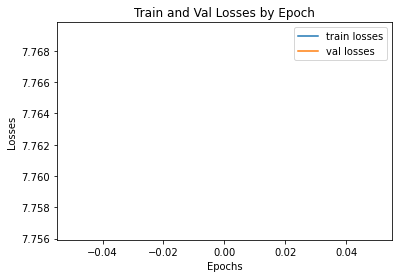

In [103]:
plt.plot(range(len(epoch_train_losses)), epoch_train_losses, label = "train losses")
plt.plot(range(len(epoch_val_losses)), epoch_val_losses, label = "val losses")


plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train and Val Losses by Epoch')
plt.legend()
plt.show()

### Serialise / Deserialise Encoder Parameters after training

In [104]:
encoder_params_after = params(encoder.emb)

In [105]:
# Serialise embedding params after training
serialise('tensor', serialise_directory, 'encoder_params_after', encoder_params_after)

In [106]:
# Deserialise embedding params after training
encoder_params_after = deserialise('tensor', serialise_directory, 'encoder_params_after')

In [107]:
# check changes in params
# encoder_params_after == encoder_params_before

In [108]:
# check gradients
# encoder.emb.weight.grad

In [109]:
# trainable / all params after training
encoder_trainable_params, encoder_all_params = num_params(encoder)
print('The encoder has {:,} trainable parameters'.format(encoder_trainable_params))
print('The encoder has {:,} parameters overall'.format(encoder_all_params))

The encoder has 552,048 trainable parameters
The encoder has 552,048 parameters overall


### Serialise / Deserialise Decoder Parameters after training

In [110]:
decoder_params_after = params(decoder.emb)

In [111]:
# Serialise embedding params after training
serialise('tensor', serialise_directory, 'decoder_params_after', decoder_params_after)

In [112]:
# Deserialise embedding params after training
decoder_params_after = deserialise('tensor', serialise_directory, 'decoder_params_after')

In [113]:
# check changes in params
# decoder_params_after == decoder_params_before

In [114]:
# check gradients
# decoder.emb.weight.grad

In [115]:
# trainable / all params after training
decoder_trainable_params, decoder_all_params = num_params(decoder)
print('The decoder has {:,} trainable parameters'.format(decoder_trainable_params))
print('The decoder has {:,} parameters overall'.format(decoder_all_params))

The decoder has 713,655 trainable parameters
The decoder has 713,655 parameters overall


## Evaluating on test data

To evaluate the data on the held-out test set, the code is exactly the same as the validation loop in the training routine we saw in the previous step. 

The test set should be run as little as possible. Each time you run a trained model on the test set, make a new model decision (such as changing the size of the layers), and remeasure the new retrained model on the test set, you are biasing your
modeling decisions toward the test data. In other words, if you repeat that process often enough, the test set will become meaningless as an accurate measure of truly held-out data.

In [116]:
test_teacher_forcing_prob = 1       # 1: YES teacher forcing; 0: NO teacher forcing

encoder.eval() # .eval() tells PyTorch that we do not want to perform back-propagation during inference
decoder.eval()

test_loss = 0

#We use torch.no_grad() which reduces memory usage and speeds up computation.
with torch.no_grad():     #https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615/3 : torch.no_grad() deals with the autograd engine and stops it from calculating the gradients, which is the recommended way of doing validation
    for i, (x_test, y_test) in enumerate(test_loader):
        x_test = x_test.to(device)
        y_test = y_test.to(device)        

        ############################################ Encoder ###############################################            

        # Forward propagation: compute the model output 
        encoder_output, encoder_hidden = encoder(input_=x_test)

        ############################################ Decoder  ###############################################

        decoder_input = torch.tensor([y_dict_w2i['<SOS>']]).expand(len(y_test))
        decoder_hidden = encoder_hidden
            
        for j in range(y_test.shape[-1]):
            decoder_output, decoder_hidden, attn_weights = decoder(input_=decoder_input, 
                                                                   decoder_hidden=decoder_hidden,
                                                                   encoder_output=encoder_output)
                
            # Get the index of the token with the highest score 
            max_value, max_idx = decoder_output.max(dim=1)

            if random.random() < test_teacher_forcing_prob:
                teacher_forcing = True
            else: 
                teacher_forcing = False

            if teacher_forcing == True:
                decoder_input = y_test[:,j]
            else:
                decoder_input = max_idx

#             decoder_hidden = decoder_hidden

            # Loss calculation
            token_loss = loss_func(decoder_output, y_test[:,j].long())
            test_loss += token_loss
            
print('Test Loss: {:.6f}'.format(test_loss/y_test_tot_tokens))
print('Done!')

Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch

Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch

Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([2

Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([256, 1, 302])
Decoder hidden shape: torch.Size([1, 256, 2])
Decoder context vector shape: torch.Size([256, 1, 2])
Decoder concat shape: torch.Size([256, 302])
Decoder concat shape: torch.Size([2

Decoder concat shape: torch.Size([177, 302])
Decoder concat shape: torch.Size([177, 1, 302])
Decoder hidden shape: torch.Size([1, 177, 2])
Decoder context vector shape: torch.Size([177, 1, 2])
Decoder concat shape: torch.Size([177, 302])
Decoder concat shape: torch.Size([177, 1, 302])
Decoder hidden shape: torch.Size([1, 177, 2])
Decoder context vector shape: torch.Size([177, 1, 2])
Decoder concat shape: torch.Size([177, 302])
Decoder concat shape: torch.Size([177, 1, 302])
Decoder hidden shape: torch.Size([1, 177, 2])
Decoder context vector shape: torch.Size([177, 1, 2])
Decoder concat shape: torch.Size([177, 302])
Decoder concat shape: torch.Size([177, 1, 302])
Decoder hidden shape: torch.Size([1, 177, 2])
Decoder context vector shape: torch.Size([177, 1, 2])
Decoder concat shape: torch.Size([177, 302])
Decoder concat shape: torch.Size([177, 1, 302])
Decoder hidden shape: torch.Size([1, 177, 2])
Decoder context vector shape: torch.Size([177, 1, 2])
Decoder concat shape: torch.Size([1

## Save and Reload models

In [117]:
path_enc = r'C:\Users\Mari\Desktop\MACHINE_LEARNING\NLP_Stanford_University\BOOK\NMT\saved_model\nmt_encoder.pth'
path_dec = r'C:\Users\Mari\Desktop\MACHINE_LEARNING\NLP_Stanford_University\BOOK\NMT\saved_model\nmt_decoder.pth'

In [118]:
# Saved encoder and decoder learned parameters
torch.save(encoder.state_dict(), path_enc)
torch.save(decoder.state_dict(), path_dec)

In [119]:
# Load encoder and decoder learned parameters

encoder.load_state_dict(torch.load(path_enc))
decoder.load_state_dict(torch.load(path_dec))

encoder.eval()
decoder.eval()

Decoder_Bahdanau_GRU(
  (emb): Embedding(2357, 300, padding_idx=0)
  (v): Linear(in_features=1, out_features=1, bias=False)
  (w1): Linear(in_features=2, out_features=1, bias=False)
  (w2): Linear(in_features=2, out_features=1, bias=False)
  (gru): GRU(302, 2, batch_first=True)
  (fc1): Linear(in_features=2, out_features=2357, bias=False)
  (dropout): Dropout(p=0.0, inplace=False)
  (log_softmax): LogSoftmax(dim=1)
)

## Inference on unseen data

In [120]:
infer_dataset = ['He is making great progress in English.']
infer_batch_size = len(infer_dataset)

infer_dataset_clean = prepare_new_data(lst_of_lsts=infer_dataset, source_TOK=S_TOK, 
                                       source_dict=X_dict_w2i, source_max_len=s_max_len)
print(type(infer_dataset_clean))
print(infer_dataset_clean.shape)
print(infer_dataset_clean)

#  THis allows to have different batch sizes in training vs in inference without raising an error
infer_dataloader = DataLoader(dataset=infer_dataset_clean, batch_size=infer_batch_size, shuffle=False, num_workers=4)

<class 'torch.Tensor'>
torch.Size([1, 26])
tensor([[  78,   38,  502,  532, 1719,   25,  852,    5,    6,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0]], dtype=torch.int32)


In [121]:
infer_encoder_decoder(infer_dataloader, 10, y_dict_w2i, y_dict_i2w)

0
Decoder context vector shape: torch.Size([1, 1, 2])
Decoder concat shape: torch.Size([1, 302])
Decoder concat shape: torch.Size([1, 1, 302])
Decoder hidden shape: torch.Size([1, 1, 2])
max idx: tensor([1040]) --- top word: crie --- max value: tensor([-7.2710])
1
Decoder context vector shape: torch.Size([1, 1, 2])
Decoder concat shape: torch.Size([1, 302])
Decoder concat shape: torch.Size([1, 1, 302])
Decoder hidden shape: torch.Size([1, 1, 2])
max idx: tensor([2332]) --- top word: cloue --- max value: tensor([-7.3425])
2
Decoder context vector shape: torch.Size([1, 1, 2])
Decoder concat shape: torch.Size([1, 302])
Decoder concat shape: torch.Size([1, 1, 302])
Decoder hidden shape: torch.Size([1, 1, 2])
max idx: tensor([2332]) --- top word: cloue --- max value: tensor([-7.3995])
3
Decoder context vector shape: torch.Size([1, 1, 2])
Decoder concat shape: torch.Size([1, 302])
Decoder concat shape: torch.Size([1, 1, 302])
Decoder hidden shape: torch.Size([1, 1, 2])
max idx: tensor([1745]

In [122]:
def infer_beam_search(dataloader, time_steps, beam_size, y_dict_w2i, y_dict_i2w):
    encoder.eval() # .eval() tells PyTorch that we do not want to perform back-propagation during inference
    decoder.eval()
    
    with torch.no_grad():
        for i, new_data in enumerate(dataloader):
            new_data = new_data.to(device)

            encoder_output, encoder_hidden = encoder(input_=new_data)
            decoder_hidden = encoder_hidden
            decoder_input = torch.tensor([y_dict_w2i['<SOS>']]).expand(len(new_data))

            for _ in range(time_steps):
                print(_)
                decoder_output, decoder_hidden, attn_weights = decoder(input_=decoder_input, 
                                                                       decoder_hidden=decoder_hidden,
                                                                       encoder_output=encoder_output)

                topk_values, topk_idx = torch.topk(decoder_output, beam_size)
                max_value, max_idx = decoder_output.max(dim=1)
                print('max idx: {} --- top word: {} --- max value: {}'.format(max_idx, 
                                                                              y_dict_i2w[str(max_idx.item())], 
                                                                              max_value))

                decoder_input = max_idx

In [123]:
x = torch.arange(1., 6.)
torch.topk(x, 3)

torch.return_types.topk(
values=tensor([5., 4., 3.]),
indices=tensor([4, 3, 2]))